<img src="../../docs/images/dlsia.png" width=600 />

# Latent Space Exploration with Randomized Sparse Mixed Scale Autoencoders, regularized by the availability of image labels

Authors: Eric Roberts and Petrus Zwart

E-mail: PHZwart@lbl.gov, EJRoberts@lbl.gov
___

This notebook highlights some basic functionality with the dlsia package.

In this notebook we setup autoencoders, with the goal to explore the latent space it generates. In this case however, we will guide the formation of the latent space by including labels to specific images.

The autoencoders we use are based on randomly construct convolutional neural networks in which we can control the number of parameters it contains. This type of control can be beneficial when the amount of data on which one can train a network is not very voluminous, as it allows for better handles on overfitting.

The constructed latent space can be used for unsupervised and supervised exploration methods. In our limited experience, the classifiers that are trained come out of the data are reasonable, but can be improved upon using classic classification methods, as shown further.

___




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from dlsia.core import helpers
from dlsia.core import train_scripts
from dlsia.core.networks import sparsenet
from dlsia.test_data.two_d import random_shapes
from dlsia.core.utils import latent_space_viewer
from dlsia.viz_tools import plots
from dlsia.viz_tools import plot_autoencoder_image_classification as paic

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import einops
import umap

from IPython.display import Image

Create some data first

In [2]:
N_train = 500
N_labeled = 250

N_test  = 5000
noise_level = 0.350
Nxy = 32

train_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_train,
                                                        noise_level=noise_level,
                                                        n_xy=Nxy)
test_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_test,
                                                       noise_level=noise_level,
                                                       n_xy=Nxy)


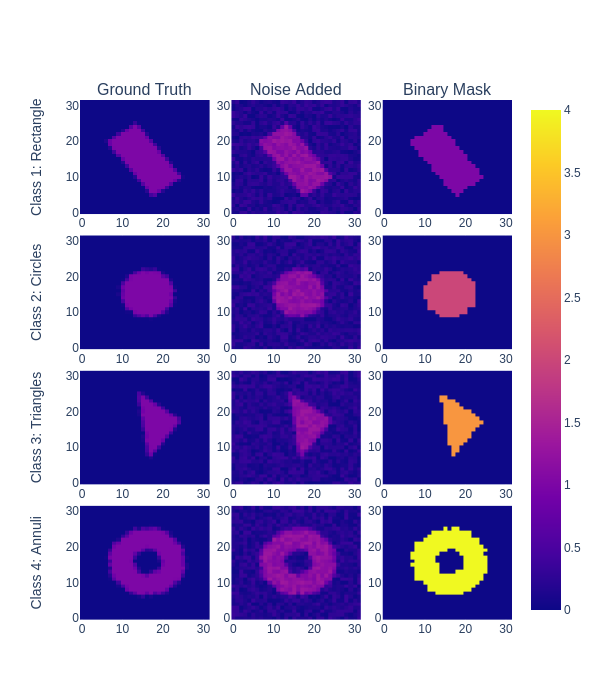

In [3]:
# normally we would use interactive plot here via
# plots.plot_shapes_data_numpy(train_data).show()
# but they don't survive when displayed in github, so
# we make it a static plot instead.
tmp = plots.plot_shapes_data_numpy(train_data)
tmp = tmp.to_image(format="png", scale=1.0)
Image(tmp)

In [4]:
which_one = "Noisy" #"GroundTruth" 

batch_size = 100

loader_params = {'batch_size': batch_size, 
                 'shuffle': True} 
train_imgs = torch.Tensor(train_data[which_one]).unsqueeze(1)
train_labels = torch.Tensor(train_data["Label"]).unsqueeze(1)-1
train_labels[N_labeled:]=-1 # remove some labels to highlight 'mixed' training

Ttrain_data = TensorDataset(train_imgs,train_labels)
train_loader = DataLoader(Ttrain_data, **loader_params)

loader_params = {'batch_size': batch_size, 
                 'shuffle': False} 
test_images = torch.Tensor(test_data[which_one]).unsqueeze(1)
test_labels = torch.Tensor(test_data["Label"]).unsqueeze(1)-1
Ttest_data = TensorDataset( test_images, test_labels ) 
test_loader = DataLoader(Ttest_data, **loader_params)


Lets build an autoencoder first.

There are a number of parameters to play with that impact the size of the network:

    - latent_shape: the spatial footprint of the image in latent space. 
      I don't recommend going below 4x4, because it interferes with the 
      dilation choices. This is a bit of a annoyiong feature, we need to fix that. 
      Its on the list.
    - out_channels: the number of channels of the latent image. Determines the
      dimension of latent space: (channels,latent_shape[-2], latent_shape[-1])
    - depth: the depth of the random sparse convolutional encoder / decoder
    - hidden channels: The number of channels put out per convolution. 
    - max_degree / min_degree : This determines how many connections you have per node.
    
    
Other parameters do not impact the size of the network dramatically / at all:

    - in_shape: determined by the input shape of the image.
    - dilations: the maximum dilation should not exceed the smallest image dimension.
    - alpha_range: determines the type of graphs (wide vs skinny). When alpha is large,
                   the chances for skinny graphs to be generated increases. 
                   We don't know which parameter choice is best, so we randomize it's choice.
    - gamma_range: no effect unless the maximum degree and min_degree are far apart.
                   We don't know which parameter choice is best, so we randomize it's choice.
    - pIL,pLO,IO: keep as is. 
    - stride_base: make sure your latent image size can be generated from the in_shape 
                   by repeated division of with this number.

For the classification, specify the number of output classes. Here we work with 4 shapes, so set it to 4.
The dropout rate governs the dropout layers in the classifier part of the networks and doesn't affect the autoencoder part.

In [5]:
autoencoder = sparsenet.SparseAEC(in_shape=(32, 32), 
                                  latent_shape=(8, 8), 
                                  out_classes=4,
                                  depth=40, 
                                  dilations=[1,2,3], 
                                  hidden_channels=3, 
                                  out_channels=1, 
                                  alpha_range=(0.5, 1.0), 
                                  gamma_range=(0.0, 0.5), 
                                  max_degree=7, min_degree=3, 
                                  pIL=0.15, 
                                  pLO=0.15, 
                                  IO=False, 
                                  stride_base=2, 
                                  dropout_rate=0.05,)

                
pytorch_total_params = helpers.count_parameters(autoencoder)
print( "Number of parameters:", pytorch_total_params)

Number of parameters: 97852


We define two optimizers, one for autoencoding and one for classification. They will be minimized consequetively instead of building a single sum of targets. This avoids choosing the right weight. 
The mini-epochs are the number of epochs it passes over the whole data set to optimize a single atrget function. The autoencoder is done first.

In [6]:
torch.cuda.empty_cache()
learning_rate = 1e-3
num_epochs=10

criterion_AE = nn.MSELoss()
optimizer_AE = optim.Adam(autoencoder.parameters(), lr=learning_rate)

criterion_label = nn.CrossEntropyLoss(ignore_index=-1)
optimizer_label = optim.Adam(autoencoder.parameters(), lr=learning_rate)


rv = train_scripts.autoencode_and_classify_training(net=autoencoder.to('cuda:0'),
                                                    trainloader=train_loader,
                                                    validationloader=test_loader,
                                                    macro_epochs=num_epochs,
                                                    mini_epochs=5,
                                                    criteria_autoencode=criterion_AE,
                                                    minimizer_autoencode=optimizer_AE,
                                                    criteria_classify=criterion_label,
                                                    minimizer_classify=optimizer_label,
                                                    device="cuda:0", 
                                                    show=1, 
                                                    clip_value=100.0)



Epoch    1,  of 10 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 3.6743e-01 | Validation Loss      : 2.9777e-01
Training CC      : 0.1593     | Validation CC        : 0.3301 
** Classification Losses **
Training Loss    : 1.4822e+00 | Validation Loss      : 1.4944e+00
Training F1 Macro: 0.1687     | Validation F1 Macro  : 0.1719 
Training F1 Micro: 0.2244     | Validation F1 Micro  : 0.2532 

Epoch    1,  of 10 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.5638e-01 | Validation Loss      : 2.0245e-01
Training CC      : 0.4177     | Validation CC        : 0.5227 
** Classification Losses **
Training Loss    : 1.4982e+00 | Validation Loss      : 1.4759e+00
Training F1 Macro: 0.1526     | Validation F1 Macro  : 0.1890 
Training F1 Micro: 0.2183     | Validation F1 Micro  : 0.2710 

Epoch    1,  of 10 >-*-< Mini Epoch     3 

Epoch    4,  of 10 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.7374e-02 | Validation Loss      : 4.8042e-02
Training CC      : 0.8186     | Validation CC        : 0.8163 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.1725e-01 | Validation Loss      : 7.2127e-01
Training F1 Macro: 0.9292     | Validation F1 Macro  : 0.8212 
Training F1 Micro: 0.9313     | Validation F1 Micro  : 0.8236 

Epoch    4,  of 10 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.8236e-02 | Validation Loss      : 4.8803e-02
Training CC      : 0.8145     | Validation CC        : 0.8131 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.7911e-01 | Validation Loss      : 6.9982e-01
Training F1 Macro: 0.9170     | Validation F1 Macro  : 0.8214 
Training F1 Micro: 0.9172     | Validation F1 Micro  : 0.8230 

Epoch    5,  of 10 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 10 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.9411e-02 | Validation Loss      : 3.1285e-02
Training CC      : 0.8921     | Validation CC        : 0.8847 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 1.7904e-01 | Validation Loss      : 5.0880e-01
Training F1 Macro: 0.9510     | Validation F1 Macro  : 0.8567 
Training F1 Micro: 0.9496     | Validation F1 Micro  : 0.8582 

Epoch    8,  of 10 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.9592e-02 | Validation Loss      : 3.1967e-02
Training CC      : 0.8902     | Validation CC        : 0.8818 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 2.1364e-01 | Validation Loss      : 5.1455e-01
Training F1 Macro: 0.9231     | Validation F1 Macro  : 0.8491 
Training F1 Micro: 0.9209     | Validation F1 Micro  : 0.8506 

Epoch    8,  of 10 >-*-< Mini Epoch     4 of 5

Visualize the loss function progression 

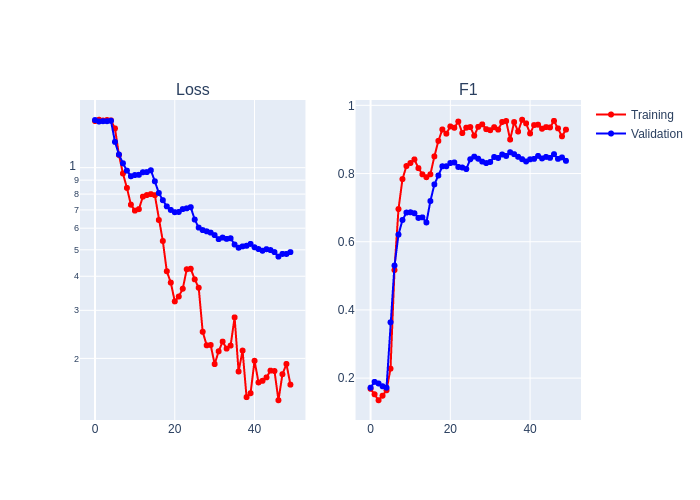

In [9]:
# normally we would use interactive plot here,
# but they don't survive when displayed in github, so
# we make it a static plot instead.

tmp = plots.plot_training_results_segmentation(rv[2])
tmp = tmp.to_image(format="png", scale=1.0)
Image(tmp)

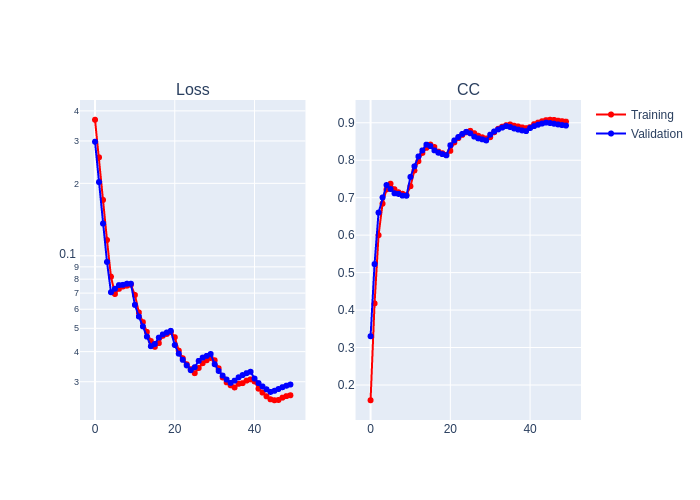

In [10]:
tmp = plots.plot_training_results_regression(rv[1])
tmp = tmp.to_image(format="png", scale=1.0)
Image(tmp)

We pass over the test data again and collect stuff so we can inspect what is happening.

In [11]:
results = []
pres = []
latent = []
true_lbl = []
inp_img = []
for batch in test_loader:
    true_lbl.append(batch[1])
    with torch.no_grad():
        inp_img.append(batch[0].cpu())
        res, ps = autoencoder(batch[0].to("cuda:0"))
        lt = autoencoder.encode(batch[0].to("cuda:0"))
        results.append(res.cpu())
        latent.append(lt.cpu())
        pres.append(ps.cpu())
results = torch.cat(results, dim=0)
latent = torch.cat(latent, dim=0)
pres = nn.Softmax(1)(torch.cat(pres,dim=0))
true_lbl = torch.cat(true_lbl, dim=0)    
inp_img = torch.cat(inp_img, dim=0)

Lets have a look and see what we get;  lets make a quick plotting utility.

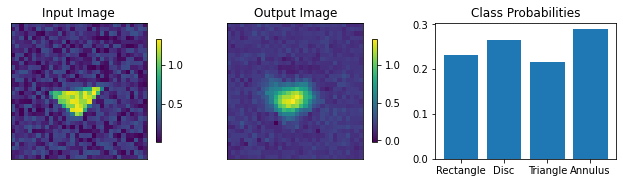

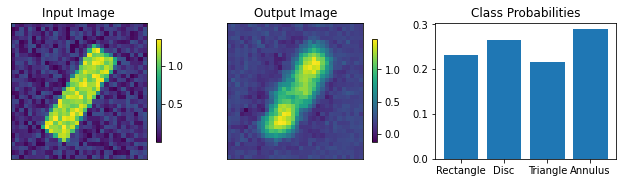

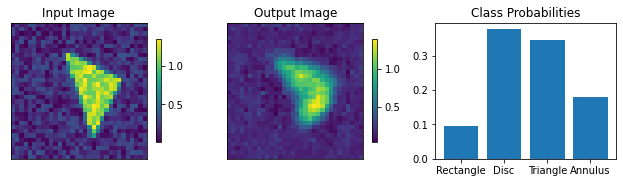

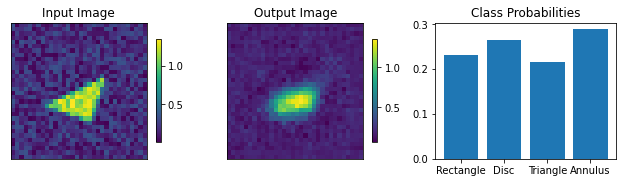

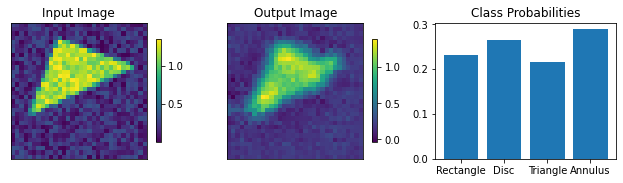

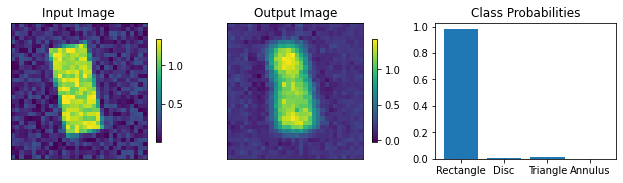

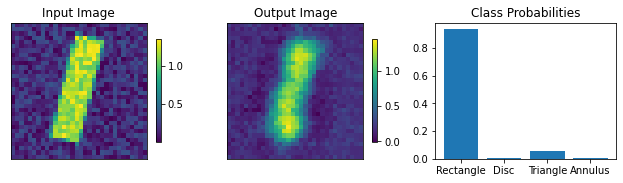

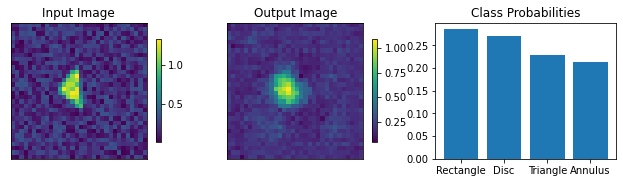

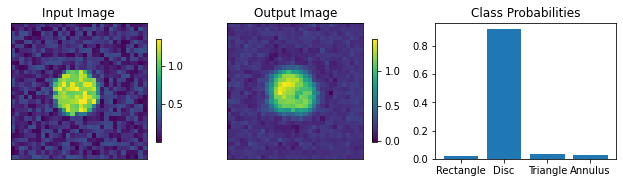

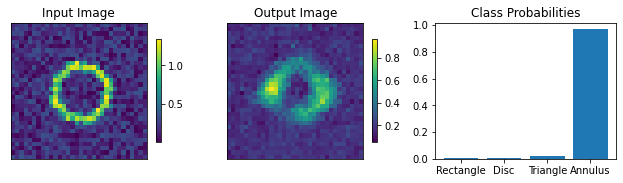

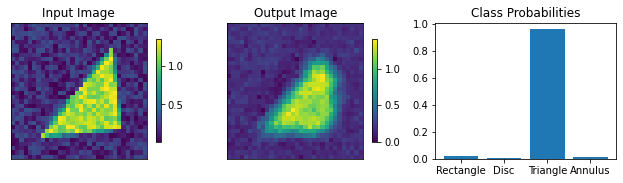

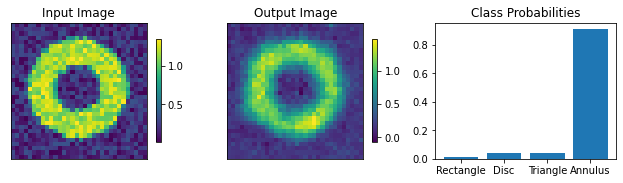

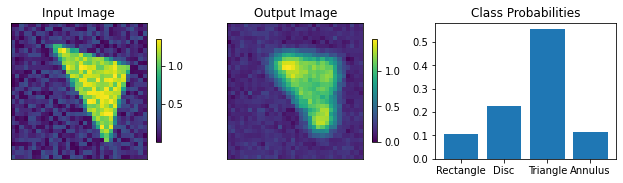

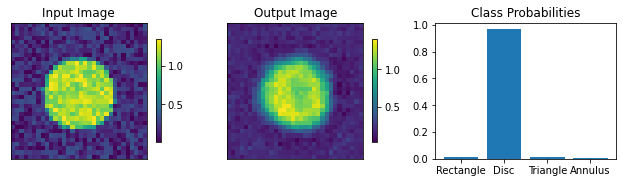

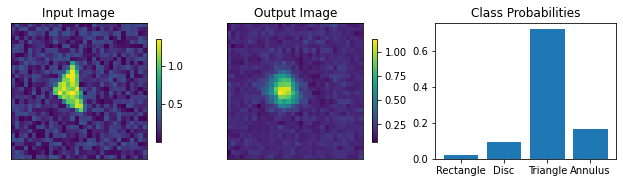

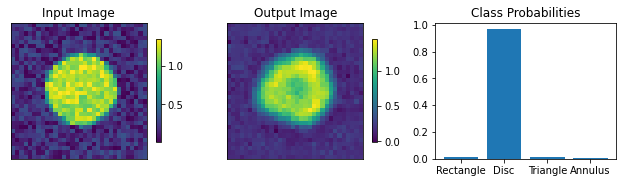

In [12]:
count = 0
for img, cc, tlbl, ori, ltl in zip(results, pres, true_lbl, inp_img, latent):
    if True: #tlbl.item() < 0:
        paic.plot_autoencoder_and_label_results(input_img=ori.numpy()[0,...], 
                                       output_img=img.numpy()[0,...], 
                                       p_classification=cc.numpy(),
                                       class_names=["Rectangle","Disc","Triangle","Annulus"])
        plt.show()
        count += 1
    if count > 15:
        break

As you see, we are doing reasonably well, but lets inspect the latent space and see whats going on. 
One can run a PCA / SVD on the latent vectors, but this is not very informative because of the dimensionality of the system. Instead, we run a UMAP and see how things look in 2D. 

It is interestiong to re-run the notebook, but without using any labels during optimization. To make this happen, just set the number of epochs to 1 and the number of mini epochs to 100 (or so). In that way, it will not reach the classification minimization. The resulting latent space will be less neat. 

In [13]:
latent = einops.rearrange(latent, "N C Y X -> N (C Y X)")
umapper = umap.UMAP(min_dist=0, n_neighbors=35)
X = umapper.fit_transform(latent.numpy())

Lets get the labels and see what we have.

We make two plots: First, we show the umapped latent space with the given labels and the unknown labels, and second, we will show the inferred / guessed labels.


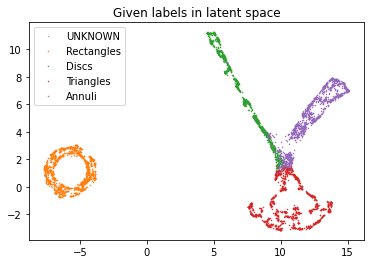

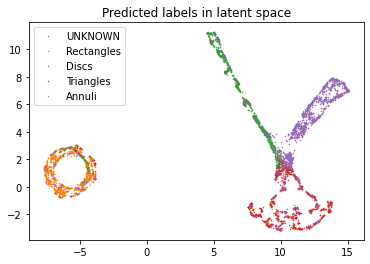

In [14]:
infered_labels = torch.argmax(pres, dim=1).numpy()+1

for lbl in [0,1,2,3,4]:
    sel = true_lbl.numpy()[:,0]+1==lbl
    ms=1
    if lbl==0:
        ms=0.5
    plt.plot(X[sel,0], X[sel,1], '.', markersize=ms)

    
plt.legend(["UNKNOWN","Rectangles","Discs","Triangles","Annuli"])
plt.title("Given labels in latent space")
plt.show()

for lbl in [0,1,2,3,4]:
    sel = infered_labels==lbl
    ms=1
    plt.plot(X[sel,0], X[sel,1], '.', markersize=ms)
plt.legend(["UNKNOWN","Rectangles","Discs","Triangles","Annuli"])
plt.title("Predicted labels in latent space")
plt.show()

As you can see, we are not perfect, lets have a look at some specific cases

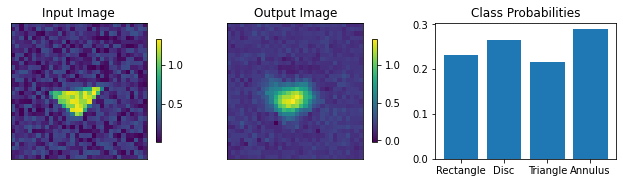

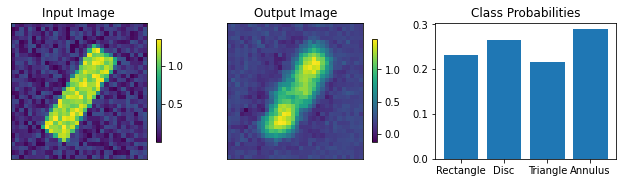

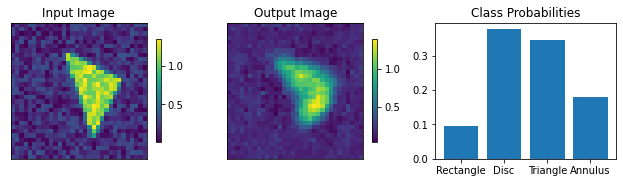

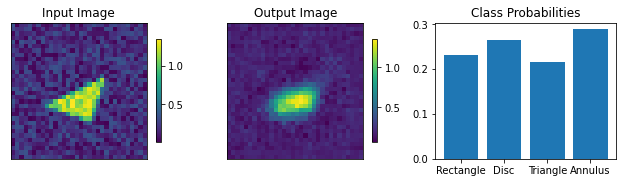

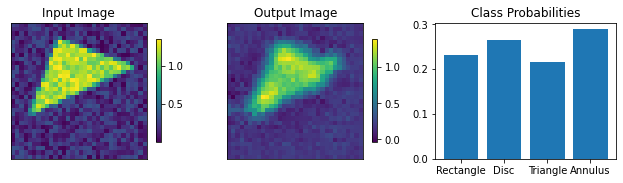

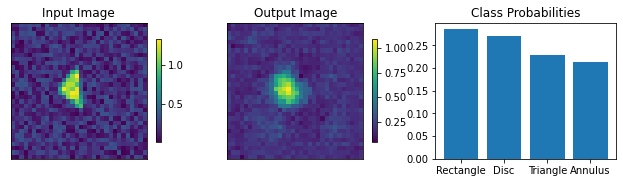

In [15]:
count = 0
for img, cc, tlbl, ori, pl in zip(results, pres, true_lbl, inp_img, infered_labels):
    if int(tlbl[0]) != pl-1:        
        paic.plot_autoencoder_and_label_results(input_img=ori.numpy()[0,...], 
                                       output_img=img.numpy()[0,...], 
                                       p_classification=cc.numpy(),
                                       class_names=["Rectangle","Disc","Triangle","Annulus"])
        plt.show()
        count += 1
    if count > 5:
        break

Last but not least, we can view our latent space

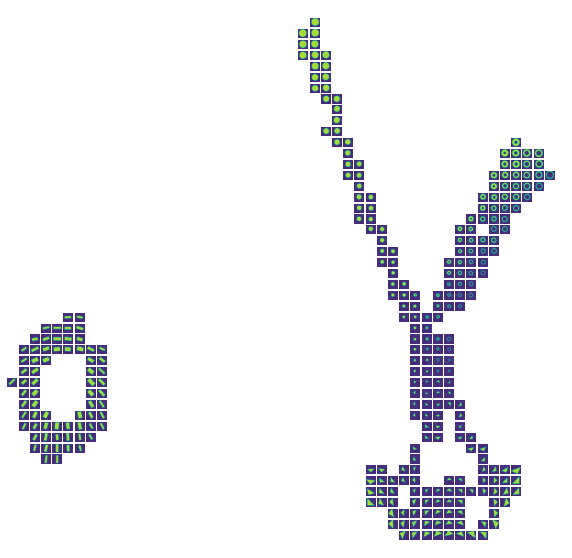

In [16]:
fig = latent_space_viewer.build_latent_space_image_viewer(inp_img.numpy()[:,0,...], 
                                X, 
                                n_bins=50, 
                                min_count=1, 
                                max_count=1, 
                                mode="nearest")